
<center>
<font color="cyan"><h2 > BreakPoint(Human in Loop)</h2></font>
<center>
<h3>interupt before</h3>
<h3>interupt before</h3>
</center>
</center>



<p>Langgraph offers several ways to get or update agent state systematically to support various human-in-loop workflows</p>
<ul>
<li>Approval : We can interupt agent, surface state to a user, and allow the user to accept an action.</li>
<li>Debugging : We can rewind the graph to reproduce or avoid issues </li>
<li>Editing : You can modify the state</li>
</ul>

Let's see the <code>breakpoints</code> , which provide a simple way to stop the graph at specific steps.


BreakPoint for Human approval
<p>All we need to do is simply compile the graph with interrupt_before=["tools"] where tools is our tools node </p>

In [4]:
# defining tools
from langchain_openai import ChatOpenAI

def multiply(a:int,b:int)-> int:
    """helps to multiply two number 

    Args:
        a : first int
        b : second int
    """
    return a*b
tools = [multiply]
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)


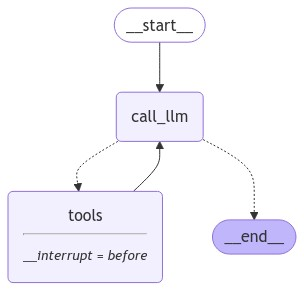

In [11]:
from langgraph.graph import START,END,StateGraph,MessagesState
from IPython.display import display,Image
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import tools_condition,ToolNode
from langgraph.checkpoint.memory import MemorySaver
system_message = SystemMessage(content="You are a helpful assistant who can perform arithmetic operations.")
#state
class State(MessagesState):
    pass

#node
def call_llm(state:State):
    response = llm_with_tools.invoke([system_message]+state['messages'])
    return {'messages':response}

# graph
builder = StateGraph(State)
builder.add_node('call_llm',call_llm)
builder.add_node('tools',ToolNode(tools))


builder.add_edge(START,'call_llm')
builder.add_conditional_edges('call_llm',tools_condition)
builder.add_edge('tools','call_llm')


#compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['tools'],checkpointer=memory)



display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
config = {'configurable':{'thread_id':1}}
events = []
for event in graph.stream({'messages':"Multiply 2 and 3"}, config,stream_mode='values'):
    events.append(event)
    print(event['messages'][-1].pretty_print())

================================ Human Message =================================

Multiply 2 and 3
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_yai3wJnsft6dfYNPhTdtyGiu)
 Call ID: call_yai3wJnsft6dfYNPhTdtyGiu
  Args:
    a: 2
    b: 3
None


In [13]:
event

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c1cc7e65-8c83-4b46-93cd-ad3e59fc9b0a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_token

In [15]:
state = graph.get_state(config)
state.next

('tools',)

In [17]:
print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c1cc7e65-8c83-4b46-93cd-ad3e59fc9b0a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'type': 'tool_call'}], usage_metadata={'input_tokens'

In [18]:
events

[{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901')]},
 {'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c1cc7e65-8c83-4b46-93cd-ad3e59fc9b0a-0', tool_calls=[{'name': '

In [19]:
len(events)

2

In [20]:
for event in graph.stream(None, config,stream_mode='values'):
    events.append(event)
    print(event['messages'][-1].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  multiply (call_yai3wJnsft6dfYNPhTdtyGiu)
 Call ID: call_yai3wJnsft6dfYNPhTdtyGiu
  Args:
    a: 2
    b: 3
None
================================= Tool Message =================================
Name: multiply

6
None
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
None


In [21]:
len(events)

5